### Prompt Segment

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [3]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

In [40]:
from PIL import Image
import requests
import cv2

# path = "Data/C12_L02_02_002_573809.jpg"
path = "./img_2.png"

image = Image.open(path)

In [41]:
prompts = ["a picture of fresh leaf", "a picture of background", "a picture of dried leaf", "a picture of spoield leaf"]

In [42]:
import torch

inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model(**inputs)
preds = outputs.logits.unsqueeze(1)

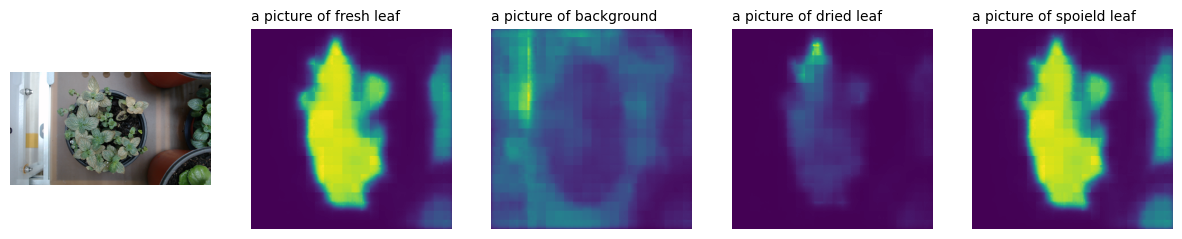

In [43]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];

### create bbox

In [44]:
def create_bbox(mask, alpha=0.5, color='red'):
    """
    Segmentation 결과에서 bbox를 생성하는 함수
    :param mask: segmentation 결과 이미지 (확률값 [0, 1]을 포함한 텐서)
    :param alpha: bbox의 불투명도 (0에서 1 사이의 값)
    :param color: bbox의 색상
    :return: bbox가 추가된 이미지
    """
    bbox_image = torch.zeros_like(mask)
    bbox_coords = torch.nonzero(mask >= 0.5)
    if bbox_coords.numel() > 0:
        y_min, x_min = bbox_coords.min(0)[0]
        y_max, x_max = bbox_coords.max(0)[0]
        bbox_image[y_min:y_max+1, x_min:x_max+1] = 1

    final_image = torch.zeros_like(mask)
    final_image = torch.where(bbox_image > 0, 1 - alpha, final_image)
    final_image = torch.where(mask > 0.5, alpha, final_image)

    return final_image

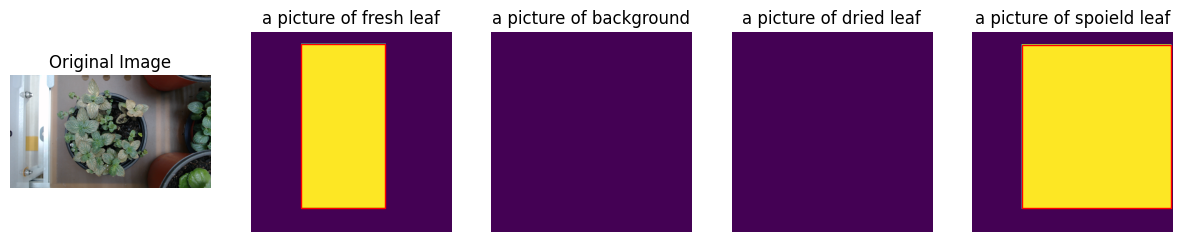

In [45]:
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

bbox_images = [create_bbox(torch.sigmoid(pred[0])) for pred in preds]

# 시각화
_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
ax[0].set_title("Original Image")

for i, bbox_image in enumerate(bbox_images):
    ax[i+1].imshow(bbox_image, cmap='viridis')
    ax[i+1].set_title(prompts[i])
    if bbox_image.max() > 0:
        bbox_coords = torch.nonzero(bbox_image > 0)
        y_min, x_min = bbox_coords.min(0)[0]
        y_max, x_max = bbox_coords.max(0)[0]
        rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
        ax[i+1].add_patch(rect)

plt.show()

### bbox segment

In [46]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator

sam_checkpoint = "../sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [47]:
import numpy as np

def find_bbox_coords(mask, threshold=0.5):
    """
    Segmentation 결과 이미지에서 객체의 bbox 좌표를 찾아 반환하는 함수
    :param mask: segmentation 결과 이미지 (확률값 [0, 1]을 포함한 텐서)
    :param threshold: segmentation 임계값 (0에서 1 사이의 값)
    :return: bbox의 좌표 (y_min, x_min, y_max, x_max)
    """
    bbox_coords = torch.nonzero(mask >= threshold)
    if bbox_coords.numel() > 0:
        y_min, x_min = bbox_coords.min(0)[0]
        y_max, x_max = bbox_coords.max(0)[0]
        return x_min, y_min, x_max, y_max
    else:
        return None

bbox_coords_list = [find_bbox_coords(torch.sigmoid(pred[0])) for pred in preds][0]
# bbox_coords_array = [np.array((coords[0].item(), coords[1].item(),
#                                coords[2].item(), coords[3].item()))
#                      for coords in bbox_coords_list]

input_box = bbox_coords_list[0].item(), bbox_coords_list[1].item(), bbox_coords_list[2].item(), bbox_coords_list[3].item()

In [16]:
input_box = np.array(input_box)

In [48]:
# path = "./C11_L01_01_001_164802.jpg"
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (352, 352))

predictor.set_image(image)

In [49]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def save_mask(src_image, mask, save_path):

    h, w = mask.shape[-2:]
    mask = mask.reshape(h, w, 1)
    mask_image = mask * src_image

    image = Image.fromarray((mask_image).astype(np.uint8))

    image = image.convert("RGBA")

    pixdata = image.load()

    width, height = image.size
    for y in range(height):
        for x in range(width):
            if mask[y, x] == False:
                pixdata[x, y] = pixdata[x, y][:3] + (0,)

    image.save(save_path)


In [50]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

TypeError: tuple indices must be integers or slices, not tuple

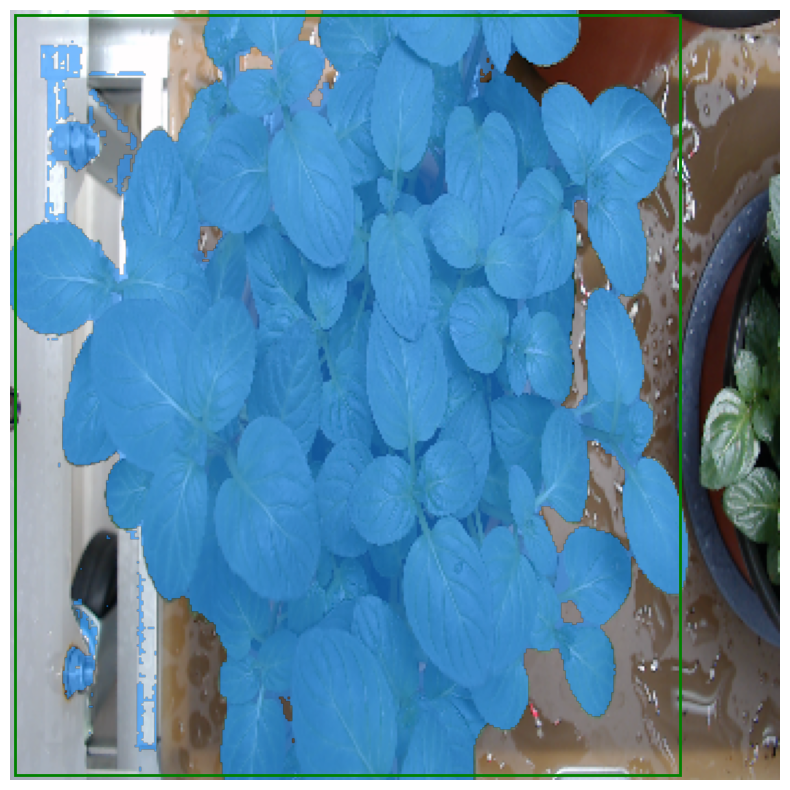

In [20]:
save_path = "./mask_test.png"

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
save_mask(image, masks[0], save_path)
plt.axis('off')
plt.show()

In [32]:
test_image = "./img_2.png"
test_image = cv2.imread(test_image)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

In [33]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [34]:
# mask_generator = SamAutomaticMaskGenerator(sam)
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.95,
    # stability_score_thresh=0.72,
    # crop_n_layers=1,
    # crop_n_points_downscale_factor=2,
    min_mask_region_area=900
)
masks = mask_generator.generate(test_image)

In [35]:
print(len(masks))

78


In [38]:
import math
def convert_segmentation_to_image(segmentation_array):
    return np.array(segmentation_array, dtype=np.uint8) * 255

def apply_mask_to_image(image, mask):
    mask_3d = np.expand_dims(mask, axis=-1)

    masked_image = image * mask_3d

    return masked_image

def plot_images_grid(images, images_per_row=4, size=(8, 8)):
    # 총 이미지 수와 행의 개수를 계산
    total_images = len(images)
    rows = math.ceil(total_images / images_per_row)

    # 플롯 생성
    fig, axes = plt.subplots(rows, images_per_row, figsize=size)
    axes = axes.flatten()  # 축을 1D 배열로 변환

    # 이미지를 축에 맞춰 그리기
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.axis('off')  # 축 제거

    # 빈 칸을 숨기기
    for i in range(len(images), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
# Convert each segmentation array to an image
segmentation_values = [item['segmentation'] for item in masks]

# Plot the images grid
plot_images_grid(segmentation_values, images_per_row=4, size=(100, 100))

# Show the plot
plt.show()

In [37]:

test_image_np = np.array(test_image)
seg_imgs = [apply_mask_to_image(test_image_np, mask['segmentation']) for mask in masks]


plot_images_grid(seg_imgs, images_per_row=4, size=(100, 100))


108


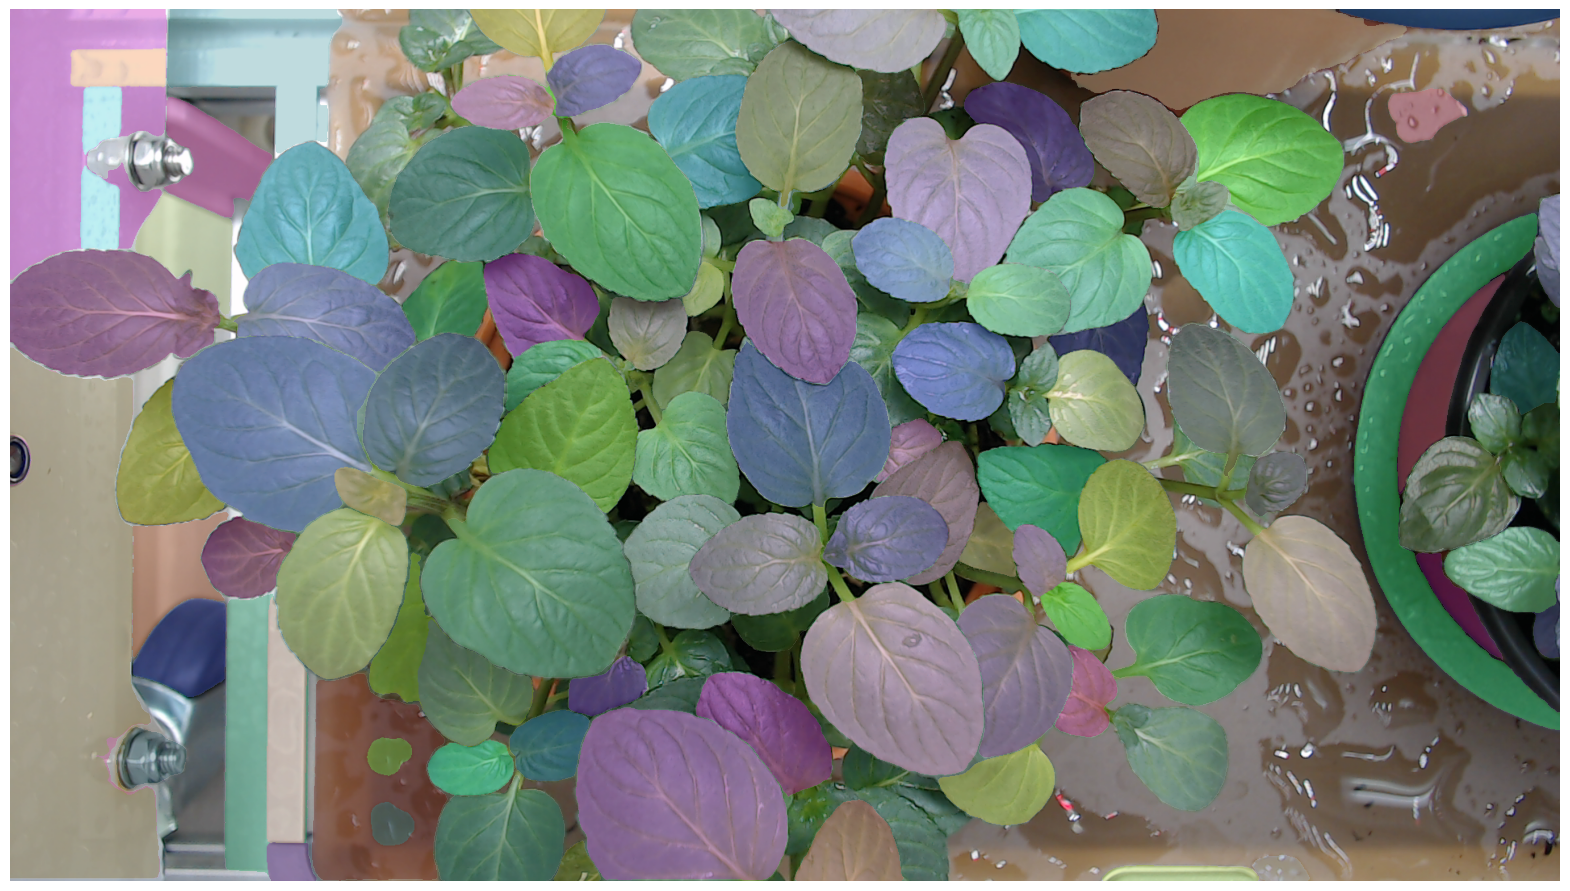

In [30]:
plt.figure(figsize=(20,20))
plt.imshow(test_image)
show_anns(masks)
print(len(masks))
plt.axis('off')
plt.show()

In [39]:
import os
from PIL import Image
for idx, img in enumerate(seg_imgs):
    sg_path = f'./classification_imgs/{idx + 1}.png'
    img = Image.fromarray(img.astype(np.uint8))
    img.save(sg_path)